In [1]:
from typing import List, Dict
import torch

import sys 
sys.path.append(".")
sys.path.append("..")

from A_E.pipeline_attend_and_excite import AttendAndExcitePipeline
from A_E.config import RunConfig
from A_E.run import run_on_prompt, get_indices_to_alter
from A_E import vis_utils
from A_E.ptp_utils import AttentionStore

%load_ext autoreload 
%autoreload 2

/home/zhouyufan/anaconda3/envs/ldm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Model Weights (may take a few minutes)

In [2]:
NUM_DIFFUSION_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
stable = AttendAndExcitePipeline.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5").to(device)
tokenizer = stable.tokenizer

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 10.30it/s]


# Pipeline Wrapper

In [3]:
# configurable parameters (see RunConfig for all parameters)
# scale factor- intensity of shift by gradient
# thresholds- a dictionary for iterative refinement mapping the iteration number to the attention threshold
# max_iter_to_alter- maximal inference timestep to apply Attend-and-Excite
def run_and_display(prompts: List[str],
                    controller: AttentionStore,
                    indices_to_alter: List[int],
                    generator: torch.Generator,
                    run_standard_sd: bool = False,
                    scale_factor: int = 20,
                    thresholds: Dict[int, float] = {0: 0.05, 10: 0.5, 20: 0.8},
                    max_iter_to_alter: int = 25,
                    display_output: bool = False):
    config = RunConfig(prompt=prompts[0],
                       run_standard_sd=run_standard_sd,
                       scale_factor=scale_factor,
                       thresholds=thresholds,
                       max_iter_to_alter=max_iter_to_alter)
    image = run_on_prompt(model=stable,
                          prompt=prompts,
                          controller=controller,
                          token_indices=indices_to_alter,
                          seed=generator,
                          config=config)
    if display_output:
        display(image)
    return image

# Show Cross-Attention Per Strengthened Token

## Define your seeds, prompt and the indices to strengthen

In [7]:
prompt = "a mix of frog and cat"
seeds = [125,126,127,128]

In [8]:
token_indices = get_indices_to_alter(stable, prompt)

{1: 'a', 2: 'mix', 3: 'of', 4: 'frog', 5: 'and', 6: 'cat'}


Altering tokens: ['frog', 'cat']


## Stable Diffusion

In [9]:
for seed in seeds:
    g = torch.Generator('cuda').manual_seed(seed)
    prompts = [prompt]
    controller = AttentionStore()
    image = run_and_display(prompts=prompts,
                            controller=controller,
                            indices_to_alter=token_indices,
                            generator=g,
                            run_standard_sd=True,
                            display_output=True)
    vis_utils.show_cross_attention(attention_store=controller,
                                   prompt=prompt,
                                   tokenizer=tokenizer,
                                   res=16,
                                   from_where=("up", "down", "mid"),
                                   indices_to_alter=token_indices,
                                   orig_image=image)

/home/zhouyufan/Projects/Idea/DE/NewIdea/blend_concept/A_E/pipeline_attend_and_excite.py:463: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  num_channels_latents = self.unet.in_channels
  0%|          | 0/50 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB. GPU 0 has a total capacity of 23.65 GiB of which 462.12 MiB is free. Process 3482633 has 15.14 GiB memory in use. Including non-PyTorch memory, this process has 8.04 GiB memory in use. Of the allocated memory 7.58 GiB is allocated by PyTorch, and 13.67 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## Attend-and-Excite

  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.7082
Iteration 1 | Loss: 0.2483


  4%|▍         | 2/50 [00:00<00:11,  4.27it/s]

Iteration 2 | Loss: 0.5175
Iteration 3 | Loss: 0.1351


  8%|▊         | 4/50 [00:00<00:08,  5.32it/s]

Iteration 4 | Loss: 0.1179
Iteration 5 | Loss: 0.0633


 12%|█▏        | 6/50 [00:01<00:07,  5.71it/s]

Iteration 6 | Loss: 0.0555
Iteration 7 | Loss: 0.0775


 16%|█▌        | 8/50 [00:01<00:07,  5.92it/s]

Iteration 8 | Loss: 0.0608
Iteration 9 | Loss: 0.0712


 20%|██        | 10/50 [00:01<00:06,  6.04it/s]

Iteration 10 | Loss: 0.1006
Iteration 11 | Loss: 0.0776


 24%|██▍       | 12/50 [00:02<00:06,  6.10it/s]

Iteration 12 | Loss: 0.0686
Iteration 13 | Loss: 0.1025


 28%|██▊       | 14/50 [00:02<00:05,  6.07it/s]

Iteration 14 | Loss: 0.0781
Iteration 15 | Loss: 0.0908


 32%|███▏      | 16/50 [00:02<00:05,  6.04it/s]

Iteration 16 | Loss: 0.1079
Iteration 17 | Loss: 0.0844


 36%|███▌      | 18/50 [00:03<00:05,  6.04it/s]

Iteration 18 | Loss: 0.1435
Iteration 19 | Loss: 0.1089


 40%|████      | 20/50 [00:03<00:04,  6.01it/s]

Iteration 20 | Loss: 0.0801
Iteration 21 | Loss: 0.1315


 44%|████▍     | 22/50 [00:03<00:04,  6.01it/s]

Iteration 22 | Loss: 0.1533
Iteration 23 | Loss: 0.0904


 50%|█████     | 25/50 [00:04<00:03,  6.49it/s]

Iteration 24 | Loss: 0.1048


100%|██████████| 50/50 [00:07<00:00,  6.83it/s]


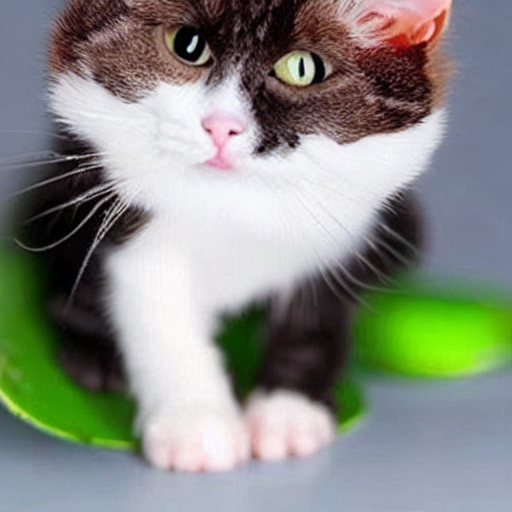

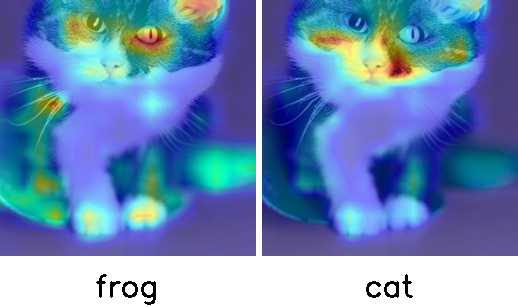

  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.9375
Iteration 1 | Loss: 0.8779


  4%|▍         | 2/50 [00:00<00:10,  4.56it/s]

Iteration 2 | Loss: 0.8834
Iteration 3 | Loss: 0.5939


  8%|▊         | 4/50 [00:00<00:08,  5.69it/s]

Iteration 4 | Loss: 0.6165
Iteration 5 | Loss: 0.2835


 12%|█▏        | 6/50 [00:01<00:07,  6.15it/s]

Iteration 6 | Loss: 0.0980
Iteration 7 | Loss: 0.0727


 16%|█▌        | 8/50 [00:01<00:06,  6.38it/s]

Iteration 8 | Loss: 0.1586
Iteration 9 | Loss: 0.0465


 20%|██        | 10/50 [00:01<00:06,  6.42it/s]

Iteration 10 | Loss: 0.1139
Iteration 11 | Loss: 0.0579


 24%|██▍       | 12/50 [00:02<00:05,  6.42it/s]

Iteration 12 | Loss: 0.0960
Iteration 13 | Loss: 0.0665


 28%|██▊       | 14/50 [00:02<00:05,  6.44it/s]

Iteration 14 | Loss: 0.0590
Iteration 15 | Loss: 0.0573


 32%|███▏      | 16/50 [00:02<00:05,  6.43it/s]

Iteration 16 | Loss: 0.0548
Iteration 17 | Loss: 0.0539


 36%|███▌      | 18/50 [00:02<00:04,  6.41it/s]

Iteration 18 | Loss: 0.0519
Iteration 19 | Loss: 0.0501


 40%|████      | 20/50 [00:03<00:04,  6.41it/s]

Iteration 20 | Loss: 0.0491
Iteration 21 | Loss: 0.0593


 44%|████▍     | 22/50 [00:03<00:04,  6.53it/s]

Iteration 22 | Loss: 0.0563
Iteration 23 | Loss: 0.0556


 50%|█████     | 25/50 [00:03<00:03,  7.02it/s]

Iteration 24 | Loss: 0.0553


100%|██████████| 50/50 [00:06<00:00,  7.31it/s]


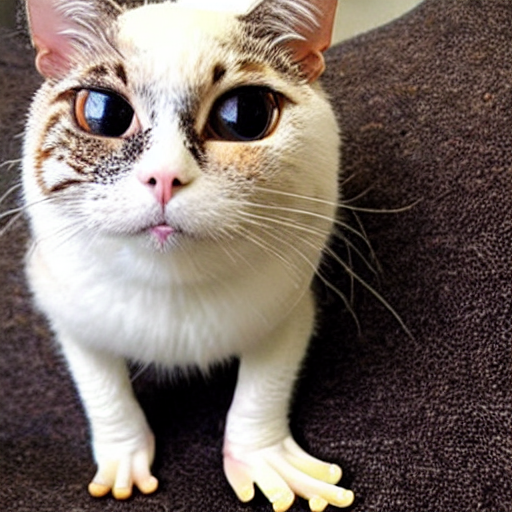

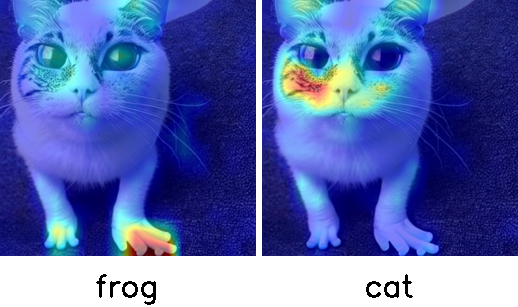

  0%|          | 0/50 [00:00<?, ?it/s]

	 Try 1. cat has a max attention of 0.045206598937511444
	 Try 2. cat has a max attention of 0.14607934653759003
	 Finished with loss of: 0.32438790798187256
Iteration 0 | Loss: 0.3244
Iteration 1 | Loss: 0.1991


  4%|▍         | 2/50 [00:00<00:20,  2.38it/s]

Iteration 2 | Loss: 0.1956
Iteration 3 | Loss: 0.4696


  8%|▊         | 4/50 [00:01<00:11,  4.11it/s]

Iteration 4 | Loss: 0.6534
Iteration 5 | Loss: 0.6747


 12%|█▏        | 6/50 [00:01<00:08,  5.15it/s]

Iteration 6 | Loss: 0.7689
Iteration 7 | Loss: 0.0391


 16%|█▌        | 8/50 [00:01<00:07,  5.62it/s]

Iteration 8 | Loss: 0.0311
Iteration 9 | Loss: 0.0278


 20%|██        | 10/50 [00:02<00:06,  5.85it/s]

Iteration 10 | Loss: 0.0360
Iteration 11 | Loss: 0.0356


 24%|██▍       | 12/50 [00:02<00:06,  5.99it/s]

Iteration 12 | Loss: 0.0448
Iteration 13 | Loss: 0.0407


 28%|██▊       | 14/50 [00:02<00:05,  6.03it/s]

Iteration 14 | Loss: 0.0451
Iteration 15 | Loss: 0.0457


 32%|███▏      | 16/50 [00:03<00:05,  6.04it/s]

Iteration 16 | Loss: 0.0477
Iteration 17 | Loss: 0.0485


 36%|███▌      | 18/50 [00:03<00:05,  6.07it/s]

Iteration 18 | Loss: 0.0562
Iteration 19 | Loss: 0.0523


 40%|████      | 20/50 [00:03<00:04,  6.11it/s]

Iteration 20 | Loss: 0.0629
Iteration 21 | Loss: 0.0582


 44%|████▍     | 22/50 [00:04<00:04,  6.02it/s]

Iteration 22 | Loss: 0.0619
Iteration 23 | Loss: 0.0599


 50%|█████     | 25/50 [00:04<00:03,  6.55it/s]

Iteration 24 | Loss: 0.0601


100%|██████████| 50/50 [00:07<00:00,  6.49it/s]


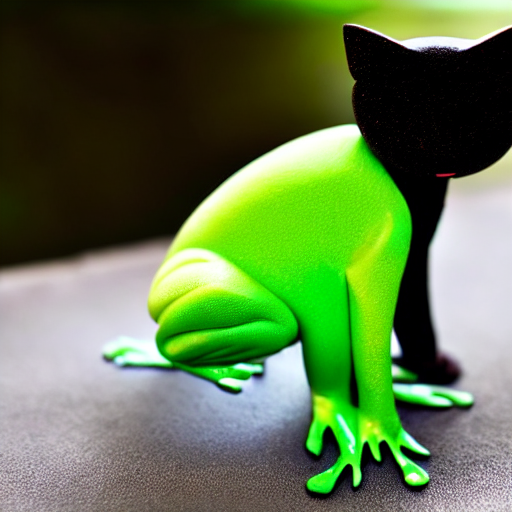

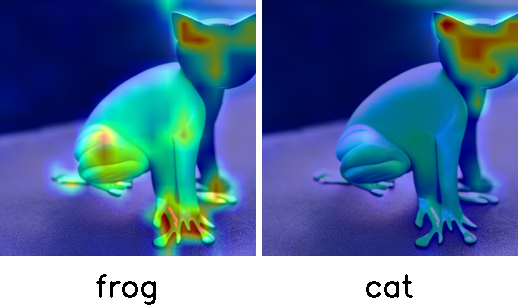

  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.9069
Iteration 1 | Loss: 0.5831


  4%|▍         | 2/50 [00:00<00:10,  4.61it/s]

Iteration 2 | Loss: 0.5877
Iteration 3 | Loss: 0.2367


  8%|▊         | 4/50 [00:00<00:08,  5.68it/s]

Iteration 4 | Loss: 0.1614
Iteration 5 | Loss: 0.1409


 12%|█▏        | 6/50 [00:01<00:07,  6.10it/s]

Iteration 6 | Loss: 0.1454
Iteration 7 | Loss: 0.1077


 16%|█▌        | 8/50 [00:01<00:06,  6.33it/s]

Iteration 8 | Loss: 0.0983
Iteration 9 | Loss: 0.0706


 20%|██        | 10/50 [00:01<00:06,  6.51it/s]

Iteration 10 | Loss: 0.0752
Iteration 11 | Loss: 0.0644


 24%|██▍       | 12/50 [00:02<00:05,  6.38it/s]

Iteration 12 | Loss: 0.0700
Iteration 13 | Loss: 0.0632


 28%|██▊       | 14/50 [00:02<00:05,  6.48it/s]

Iteration 14 | Loss: 0.0722
Iteration 15 | Loss: 0.0627


 32%|███▏      | 16/50 [00:02<00:05,  6.60it/s]

Iteration 16 | Loss: 0.0601
Iteration 17 | Loss: 0.0493


 36%|███▌      | 18/50 [00:02<00:04,  6.71it/s]

Iteration 18 | Loss: 0.0558
Iteration 19 | Loss: 0.0485


 40%|████      | 20/50 [00:03<00:04,  6.60it/s]

Iteration 20 | Loss: 0.0508
Iteration 21 | Loss: 0.0494


 44%|████▍     | 22/50 [00:03<00:04,  6.54it/s]

Iteration 22 | Loss: 0.0508
Iteration 23 | Loss: 0.0535


 50%|█████     | 25/50 [00:03<00:03,  7.12it/s]

Iteration 24 | Loss: 0.0553


100%|██████████| 50/50 [00:06<00:00,  7.37it/s]


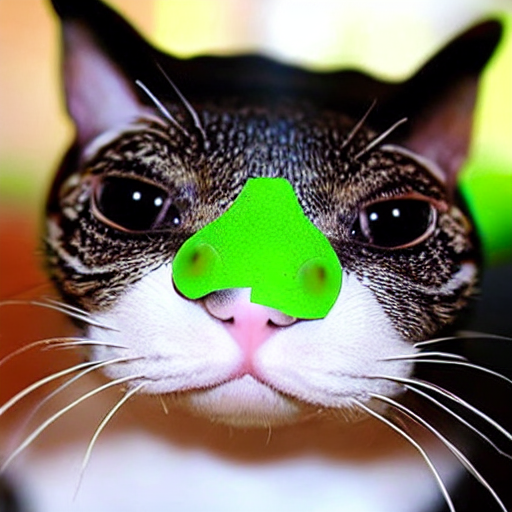

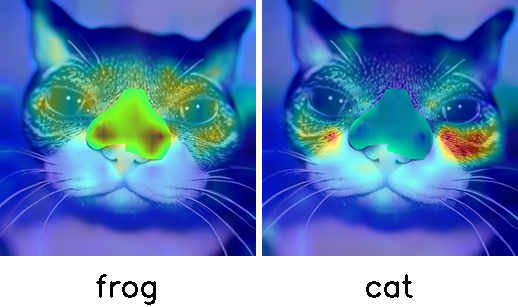

In [24]:
for seed in seeds:
    g = torch.Generator('cuda').manual_seed(seed)
    prompts = [prompt]
    controller = AttentionStore()
    image = run_and_display(prompts=prompts,
                            controller=controller,
                            indices_to_alter=token_indices,
                            generator=g,
                            run_standard_sd=False,
                            display_output=True)
    vis_utils.show_cross_attention(attention_store=controller,
                                   prompt=prompt,
                                   tokenizer=tokenizer,
                                   res=16,
                                   from_where=("up", "down", "mid"),
                                   indices_to_alter=token_indices,
                                   orig_image=image)

In [ ]:
def name_unet_submodules(unet):
    def recursive_find_module(name, module, end=False):
        if end:
            for sub_name, sub_module in module.named_children():
                sub_module.full_name = f"{name}.{sub_name}"
            return
        if not "up_blocks" in name and not "down_blocks" in name and not "mid_block" in name: return
        elif "resnets" in name: return
        for sub_name, sub_module in module.named_children():
            end = True if sub_name == "transformer_blocks" else False
            recursive_find_module(f"{name}.{sub_name}", sub_module, end)

    for name, module in unet.named_children():
        recursive_find_module(name, module)